In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
import sklearn.gaussian_process as gp
from sklearn import preprocessing
import shap
import pickle

In [18]:
#data to be used for retention estimation including a number of variables - simulated randomly
data = pd.read_csv('trial_static_data.csv')
data.head()

,n_participant,duration,age>65,male,ethnicity_white,use_technology,medication,follow_up_considered,use_wearables,use_mobile_app,...,feedback_provided,prioir_treatment_history_considered,co_mobidities_considered,treatment_type,biosamples_collected,randomised,mutli_site,adverse_event_considered,support_sessions,retention_rate
0,37485.0,47.0,0.360652,0.468075,0.813318,yes,Testosterone,yes,yes,yes,...,yes,yes,yes,behavioural,yes,yes,yes,yes,yes,0.670430
1,95074.0,67.0,0.274653,0.386949,0.780900,no,5ARI,no,no,no,...,no,no,no,observational,no,no,no,no,no,0.613048
2,73213.0,56.0,0.410607,0.496771,0.778005,no,citalopram,no,no,no,...,no,no,no,rTMS,no,no,no,no,no,0.658919
3,59886.0,52.0,0.194410,0.286842,0.661032,no,Antidepressant,no,no,no,...,no,no,no,rTMS,no,no,no,no,no,0.490143
4,15644.0,40.0,0.519845,0.651132,0.952072,yes,Escitalopram,yes,yes,yes,...,yes,yes,yes,medication,yes,yes,yes,yes,yes,0.852008


In [10]:
data.isna().any()

n_participant                          False
duration                               False
age>65                                 False
male                                   False
ethnicity_white                        False
use_technology                         False
medication                             False
follow_up_considered                   False
use_wearables                          False
use_mobile_app                         False
interviews_needed                      False
questionare_completed                  False
feedback_provided                      False
prioir_treatment_history_considered    False
co_mobidities_considered               False
treatment_type                         False
biosamples_collected                   False
randomised                             False
mutli_site                             False
adverse_event_considered               False
support_sessions                       False
retention_rate                         False
dtype: boo

In [19]:
binary_columns = [
       'use_technology', 'follow_up_considered', 'use_wearables',
       'use_mobile_app', 'interviews_needed', 'questionare_completed',
       'feedback_provided', 'prioir_treatment_history_considered',
       'co_mobidities_considered', 'biosamples_collected',
       'randomised', 'mutli_site', 'adverse_event_considered',
       'support_sessions', 'retention_rate']

for c in binary_columns:
    data.loc[data[c] == 'yes',c] = 1
    data.loc[data[c] == 'no',c] = 0
    
m = pd.get_dummies(data['medication'], prefix='medication')
t = pd.get_dummies(data['treatment_type'], prefix='treatment_type')

data.drop('medication', inplace = True,axis=1) # no data for this currently
data.drop('treatment_type', inplace = True,axis=1)

data = pd.concat([data, m, t], axis=1)
data.head()

,n_participant,duration,age>65,male,ethnicity_white,use_technology,follow_up_considered,use_wearables,use_mobile_app,interviews_needed,...,medication_5ARI,medication_Antidepressant,medication_Escitalopram,medication_Testosterone,medication_citalopram,medication_venlafaxine,treatment_type_behavioural,treatment_type_medication,treatment_type_observational,treatment_type_rTMS
0,37485.0,47.0,0.360652,0.468075,0.813318,1,1,1,1,1,...,0,0,0,1,0,0,1,0,0,0
1,95074.0,67.0,0.274653,0.386949,0.780900,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,73213.0,56.0,0.410607,0.496771,0.778005,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,59886.0,52.0,0.194410,0.286842,0.661032,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,15644.0,40.0,0.519845,0.651132,0.952072,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0


In [22]:
X = data.copy()
X.drop('retention_rate', inplace = True,axis=1)
y = data['retention_rate']

#train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [23]:
#no parameter optimisation is done as the data is just for shwoing the process
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e2)) * gp.kernels.RBF(10.0, (1e-3, 1e2))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

In [25]:
model.fit(X_train, y_train)
pickle.dump(model, open('model1', 'wb'))
y_pred, std = model.predict(X_test, return_std=True)
y_pred [y_pred>100] = 100
mse = ((y_pred-y_test)**2).mean()
mse#we need to make sure variables are within range 

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.


0.021934545324122215

Permutation explainer: 101it [01:15,  1.20it/s]                                 


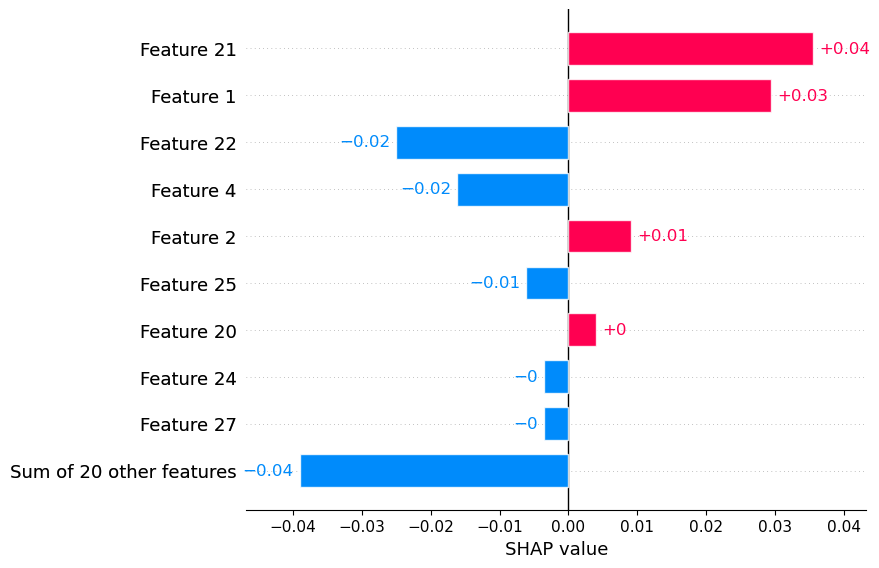

In [26]:
#feature improtance using shap
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
shap.plots.bar(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


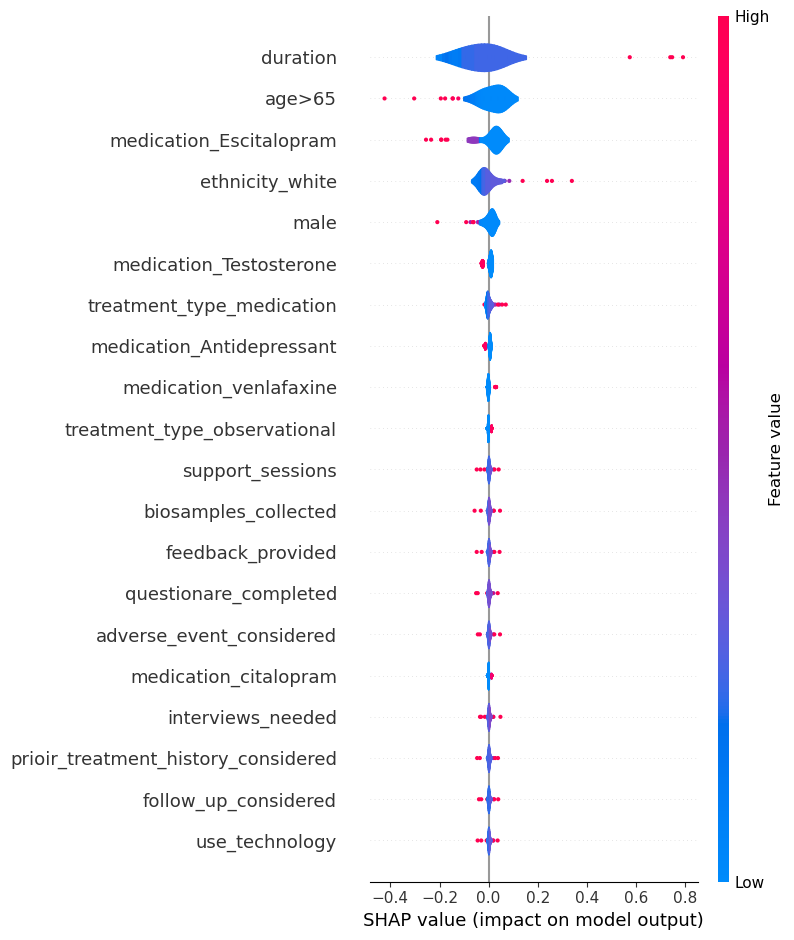

In [27]:
shap.summary_plot(shap_values, plot_type='violin',feature_names = X.columns)